In [2]:
# test.pyからのコピー
import json

import numpy as np


def load_results(output_dir='sample_video/test_data'):
    with open(f'{output_dir}/results.json', 'r') as f:
        results = json.load(f)
    return results

def evaluate():
    results = load_results()
    error = {}
    correct = {}
    count = {}
    for key in results.keys():
        sensed_count = results[key]['sensed_count']
        answer_count = results[key]['answer_count']
        sensed_speed = results[key]['sensed_speed']
        answer_speed = results[key]['answer_speed']

        movement_type = results[key]['movement_type']
        if movement_type not in error:
            error[movement_type] = []
            correct[movement_type] = 0
            count[movement_type] = 0
        error[movement_type] += [np.abs(sensed_count - answer_count)]
        # if np.abs(sensed_speed - answer_speed) < 0.0333333334*4:
        if np.abs(sensed_count - answer_count) < 1:
        # if np.abs(sensed_count - answer_count) < (answer_count * 0.10):
            correct[movement_type] += 1
        else:
            video_id = results[key]['id']
            sensor_id = results[key]['sensor_id']
            movement_type = results[key]['movement_type']
            movement_direction = results[key]['movement_direction']
            start_frame = results[key]['start_frame']
            fps = results[key]['fps']
            print(f'error: {sensed_count:.2f} - {answer_count:.2f} = {np.abs(sensed_count - answer_count):.2f} {video_id}_{sensor_id}_{movement_type}_{movement_direction} {start_frame/fps:.0f}')
        count[movement_type] += 1
    
    all_correct = 0
    all_count = 0
    for key in error.keys():
        print(f'{key} Max error: {np.max(error[key])}')
        print(f'{key} Min error: {np.min(error[key])}')
        print(f'accuarcy: {correct[key] / count[key]}')
        print()
        all_correct += correct[key]
        all_count += count[key]
    print(f'Overall accuracy: {all_correct / all_count}')



# MAPEとRMSEを計算する

In [3]:
import numpy as np

def calculate_mape(results):
    """Calculates MAPE (Mean Absolute Percentage Error) for sensed_count vs answer_count."""
    total_percentage_error = 0
    valid_count = 0
    for key in results.keys():
        answer_count = results[key]['answer_count']
        sensed_count = results[key]['sensed_count']
        if answer_count != 0:
            percentage_error = np.abs((sensed_count - answer_count) / answer_count)
            total_percentage_error += percentage_error
            valid_count += 1

    if valid_count == 0:
        return None  # Avoid division by zero if there are no valid entries
    mape = (total_percentage_error / valid_count) * 100
    return mape

def calculate_rmse_zero_answer(results):
    """Calculates RMSE (Root Mean Square Error) only for entries where answer_count is 0."""
    squared_errors = []
    for key in results.keys():
        answer_count = results[key]['answer_count']
        sensed_count = results[key]['sensed_count']
        if answer_count == 0:
            squared_error = (sensed_count - answer_count) ** 2
            squared_errors.append(squared_error)

    if len(squared_errors) == 0:
        return None  # Avoid division by zero if there are no entries with answer_count = 0
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse

result_dir = 'results/thre30'
result_dir = 'results/thre30scale4min2'
result_dir = 'results/thre30scale4min2ds30'
mape = calculate_mape(load_results(result_dir))
rmse = calculate_rmse_zero_answer(load_results(result_dir))

print(f'MAPE (for answer_count != 0): {mape:.2f}%')
print(f'RMSE (for answer_count = 0): {rmse:.2f}')


MAPE (for answer_count != 0): 9.16%
RMSE (for answer_count = 0): 3.17


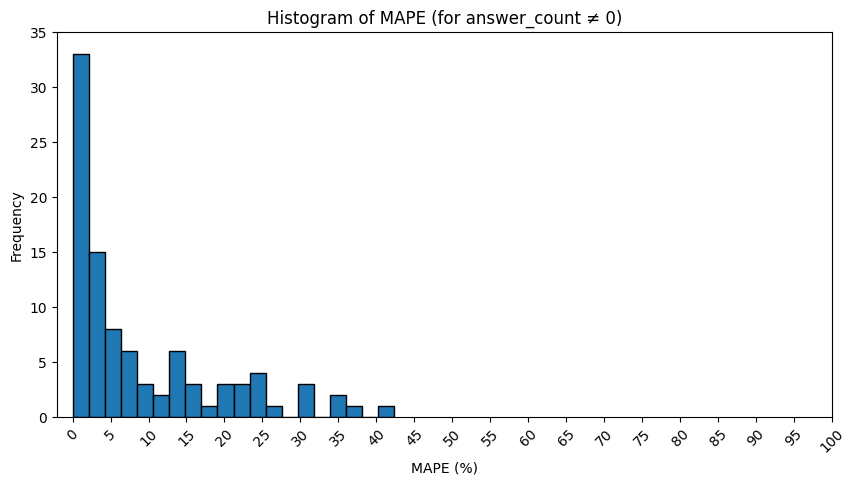

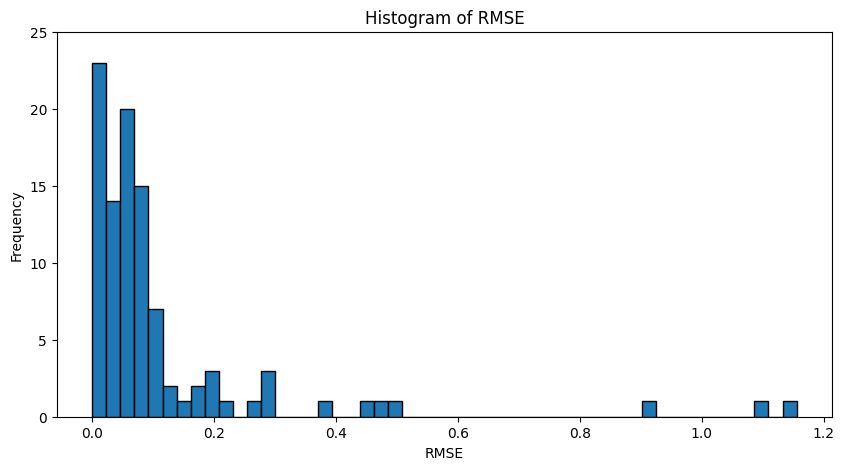

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mape_histogram(results):
    mape_values = []
    for key in results.keys():
        answer_count = results[key]['answer_count']
        sensed_count = results[key]['sensed_count']
        if answer_count != 0:
            percentage_error = np.abs((sensed_count - answer_count) / answer_count) * 100
            mape_values.append(percentage_error)
    
    plt.figure(figsize=(10, 5))
    plt.hist(mape_values, bins=20, edgecolor='k')
    plt.title("Histogram of MAPE (for answer_count ≠ 0)")
    plt.xlabel("MAPE (%)")
    plt.ylabel("Frequency")

    # 横軸の目盛りを細かく設定
    x_min, x_max = min(mape_values), max(mape_values)
    x_ticks = np.arange(0, 101, 5)
    plt.xticks(x_ticks, rotation=45)
    plt.yticks(np.arange(0, 40, 5))

    plt.savefig('mape.png')
    plt.show()

def plot_rmse_histogram(results):
    rmse_values = []
    for key in results.keys():
        answer_count = results[key]['answer_count']
        sensed_count = results[key]['sensed_count']
        # if answer_count == 0:
        squared_error = (sensed_count/30 - answer_count/30) ** 2
        rmse_values.append(np.sqrt(squared_error))
    plt.figure(figsize=(10, 5))
    plt.hist(rmse_values, bins=50, edgecolor='k')
    plt.title("Histogram of RMSE")
    plt.xlabel("RMSE")
    plt.ylabel("Frequency")

    # 横軸の目盛りを細かく設定
    x_min, x_max = min(rmse_values), max(rmse_values)
    # x_ticks = np.arange(x_min, x_max, 1)  # 20分割で表示
    # plt.xticks(x_ticks, rotation=45)
    plt.yticks(np.arange(0, 30, 5))

    plt.savefig('rmse.png')
    plt.show()

# データを読み込んでヒストグラムを表示
# result_dir = 'results/thre30'
result_dir = 'results/thre30calc_s02ds30minf10'
results = load_results(result_dir)
plot_mape_histogram(results)
plot_rmse_histogram(results)


## MAPEの大きさ別に考察

In [6]:
from modules.utils import load_samples_json
# result_dir = 'results/thre30'
result_dir = 'results/thre30scale4min2ds30'
result_dir = 'results/thre30calc_s02ds30minf10'
results = load_results(result_dir)
samples_ = load_samples_json()
samples = {}
for sample in samples_:
    samples[sample['id']] = sample

all_errors_squared = []
all_percentage_errors = []

eval_results = {}
for key in results.keys():
    sensed_count = results[key]['sensed_count']
    answer_count = results[key]['answer_count']
    
    video_id = results[key]['id']
    sensor_id = results[key]['sensor_id']
    movement_type = results[key]['movement_type']
    movement_direction = results[key]['movement_direction']
    start_frame = results[key]['start_frame']
    fps = results[key]['fps']

    sample = samples[video_id]
    sensor = sample['sensors'][sensor_id]
    w = sensor['w']
    h = sensor['h']

    error_squared = (sensed_count/30 - answer_count/30) ** 2
    all_errors_squared.append(error_squared)
    
    if answer_count != 0:
        mape = np.abs((sensed_count - answer_count) / answer_count) * 100
        success = mape < 20
        all_percentage_errors.append(mape)
    else:
        rmse = np.sqrt((sensed_count/30 - answer_count/30) ** 2)
        success = rmse < 1/30
    if f"{video_id}_{sensor_id}" not in eval_results:
        info = {
            'video_id': video_id,
            'sensor_id': sensor_id,
            'movement_type': movement_type,
            'movement_direction': movement_direction,
            'start_frame': start_frame,
            'fps': fps,
            'answer_counts': [],
            'sensed_counts': [],
            'w': w,
            'h': h,
        }
        eval_results[f"{video_id}_{sensor_id}"] = {'info': info, 'success': []}
    eval_results[f"{video_id}_{sensor_id}"]['success'].append(success)
    eval_results[f"{video_id}_{sensor_id}"]['info']['answer_counts'].append(answer_count)
    eval_results[f"{video_id}_{sensor_id}"]['info']['sensed_counts'].append(sensed_count)


mean_mape = np.mean(all_percentage_errors)
overall_rmse = np.sqrt(np.mean(all_errors_squared))

print(f"全体のMAPE: {mean_mape:.2f}%")
print(f"全体のRMSE: {overall_rmse:.2f}")

print("Success rate for each video_id_sensor_id:")
for key, values in eval_results.items():
    success_rate = np.mean(values['success'])
    eval_results[key]['success_rate'] = success_rate
    print(f"{key}: {success_rate:.2f}")


completely_successful_count = 0
questionable_count = 0
completely_failure_count = 0
all_count = len(eval_results.keys())
success_count = 0
for key in eval_results.keys():
    success_rate = eval_results[key]['success_rate']
    success_count += success_rate
    if success_rate == 1:
        completely_successful_count += 1
    elif success_rate == 0:
        completely_failure_count += 1
    else:
        questionable_count += 1

print(f"Average success rate: {success_count / all_count:.2f}")

print(f"Completely successful(100%) rate: {completely_successful_count / len(eval_results.keys()):.2f}")
print(f"Completely successful count: {completely_successful_count}")

print(f"Questionable(0% < rate < 100%) rate: {questionable_count / len(eval_results.keys()):.2f}")
print(f"Questionable count: {questionable_count}")

print(f"Completely failure(0%) rate: {completely_failure_count / len(eval_results.keys()):.2f}")
print(f"Completely failure count: {completely_failure_count}")



全体のMAPE: 9.05%
全体のRMSE: 0.23
Success rate for each video_id_sensor_id:
i9LJo7hnaDM_0: 1.00
i9LJo7hnaDM_1: 0.67
i9LJo7hnaDM_2: 0.67
i9LJo7hnaDM_3: 1.00
YZtqxxZwARE_0: 1.00
YZtqxxZwARE_1: 0.33
YZtqxxZwARE_2: 1.00
YZtqxxZwARE_3: 1.00
UmSUahKVm74_0: 0.00
UmSUahKVm74_1: 0.67
UmSUahKVm74_2: 1.00
22HBo1EI50U_0: 1.00
22HBo1EI50U_1: 1.00
feFVo3Ssp_k_0: 1.00
feFVo3Ssp_k_1: 1.00
feFVo3Ssp_k_2: 0.33
feFVo3Ssp_k_3: 0.33
FMOuqx6s9aQ_0: 1.00
FMOuqx6s9aQ_1: 1.00
FMOuqx6s9aQ_2: 1.00
l5VyqMIaL7E_0: 1.00
l5VyqMIaL7E_1: 1.00
8oFzkYH9A54_0: 0.00
8oFzkYH9A54_1: 1.00
mIFuCipTWkQ_0: 1.00
mIFuCipTWkQ_1: 1.00
mIFuCipTWkQ_2: 1.00
L6rzLUJ1QoA_0: 1.00
L6rzLUJ1QoA_1: 1.00
L6rzLUJ1QoA_2: 1.00
jkq3HWArjXg_0: 1.00
jkq3HWArjXg_1: 0.33
jkq3HWArjXg_2: 1.00
Average success rate: 0.83
Completely successful(100%) rate: 0.73
Completely successful count: 24
Questionable(0% < rate < 100%) rate: 0.21
Questionable count: 7
Completely failure(0%) rate: 0.06
Completely failure count: 2


In [205]:
# 成功率を降順にソートして表示
success_rates = {key: values['success_rate'] for key, values in eval_results.items()}
sorted_success_rates = sorted(success_rates.items(), key=lambda x: x[1], reverse=True)
print("\nSuccess rate for each video_id_sensor_id (sorted):")
for key, success_rate in sorted_success_rates:
    info = eval_results[key]['info']
    print(f"{key}: {success_rate:.2f}, {info['movement_type']}_{info['movement_direction']}, {info['fps']:.0f}fps, answer_count: {info['answer_counts'][0]}, sensed_counts: {info['sensed_counts'][0]}, {info['w']}x{info['h']}")


Success rate for each video_id_sensor_id (sorted):
i9LJo7hnaDM_0: 1.00, Conveyor Motion_Forward, 30fps, answer_count: 97, sensed_counts: 98.87856568466164, 40x40
i9LJo7hnaDM_3: 1.00, Conveyor Motion_Left, 30fps, answer_count: 0, sensed_counts: 0.0, 40x40
YZtqxxZwARE_0: 1.00, Conveyor Motion_Forward, 60fps, answer_count: 70, sensed_counts: 77.70301253875444, 40x40
YZtqxxZwARE_2: 1.00, Reciprocating Motion_Vertical, 60fps, answer_count: 68, sensed_counts: 64.55381789866405, 40x40
YZtqxxZwARE_3: 1.00, Rotary Motion_Counterclockwise, 60fps, answer_count: 72, sensed_counts: 69.4423209123711, 40x40
UmSUahKVm74_2: 1.00, Conveyor Motion_Right, 60fps, answer_count: 14, sensed_counts: 13.550717004595954, 40x40
22HBo1EI50U_0: 1.00, Conveyor Motion_Right, 30fps, answer_count: 97, sensed_counts: 97.44279146346595, 40x40
22HBo1EI50U_1: 1.00, Conveyor Motion_Forward, 30fps, answer_count: 26, sensed_counts: 25.450726656577743, 100x100
feFVo3Ssp_k_0: 1.00, Conveyor Motion_Backward, 30fps, answer_count

In [186]:
from modules.utils import load_samples_json
samples = load_samples_json()

for sample in samples:
    video_id = sample['id'].replace('_', '\\_')
    sensors = sample['sensors']
    info = sample['info']
    fps = int(np.round(info['frame_rate']))
    width = info['width']
    height = info['height']
    for i, sensor in enumerate(sensors):
        sensor_id = i + 1
        w = sensor['w']
        h = sensor['h']
        movement_type = sensor['movement']['type']
        movement_type = {'Conveyor Motion': 'Uni-dir', 'Reciprocating Motion': 'Bi-dir', 'Blinking Motion': 'On-Off', 'Rotary Motion': 'Rotate'}[movement_type]

        movement_direction = sensor['movement']['direction']
        movement_direction = {'Right': 'R', 'Left': 'L', 'Up': 'U', 'Down': 'D', 'Clockwise': 'CW', 'Counterclockwise': 'CCW', 'Forward': 'F', 'Backward': 'B', 'Horizontal': 'H', 'Vertical': 'V', 'On': 'On', 'Off': 'Off', None: '-'}[movement_direction]

        video_id_ = video_id.replace('\\', '')
        eval_info = eval_results[f'{video_id_}_{sensor_id-1}']['info']
        sensed_counts = eval_info['sensed_counts']
        answer_counts = eval_info['answer_counts']

        is_success = [np.abs((s - a) / a) * 100 < 20 if a != 0 else np.sqrt((s - a) ** 2) < 1 for s, a in zip(sensed_counts, answer_counts)]

        count_text = ' & '.join([
                        f'\\textbf{{{s/30:.2f} ({a/30:.2f})}}' if success else f'{s/30:.2f} ({a/30:.2f})'
                        for s, a, success in zip(sensed_counts, answer_counts, is_success)
                    ])

        
        if i == 0:
            print(f'{video_id} & {sensor_id} & {count_text}  \\\\'+ ' \cline{2-5}')
        elif i == len(sensors) - 1:
            print(f' & {sensor_id} & {count_text} \\\\'+ ' \hline')
        else:
            print(f' & {sensor_id} & {count_text} \\\\'+ ' \cline{2-5}')


i9LJo7hnaDM & 1 & \textbf{3.30 (3.23)} & \textbf{3.30 (3.23)} & \textbf{1.76 (1.73)}  \\ \cline{2-5}
 & 2 & \textbf{0.00 (0.00)} & 0.21 (0.00) & \textbf{1.77 (1.77)} \\ \cline{2-5}
 & 3 & \textbf{0.41 (0.43)} & 0.24 (0.17) & \textbf{0.41 (0.43)} \\ \cline{2-5}
 & 4 & \textbf{0.00 (0.00)} & \textbf{0.00 (0.00)} & \textbf{0.44 (0.47)} \\ \hline
YZtqxxZwARE & 1 & \textbf{2.59 (2.33)} & \textbf{2.61 (2.33)} & \textbf{2.71 (2.33)}  \\ \cline{2-5}
 & 2 & \textbf{2.79 (2.33)} & 2.77 (2.30) & 2.79 (2.30) \\ \cline{2-5}
 & 3 & \textbf{2.15 (2.27)} & \textbf{2.13 (2.30)} & \textbf{2.41 (2.33)} \\ \cline{2-5}
 & 4 & \textbf{2.31 (2.40)} & \textbf{2.32 (2.40)} & \textbf{2.31 (2.50)} \\ \hline
UmSUahKVm74 & 1 & 0.54 (0.43) & 0.53 (0.43) & 0.54 (0.43)  \\ \cline{2-5}
 & 2 & 0.25 (0.20) & \textbf{0.24 (0.23)} & \textbf{0.25 (0.23)} \\ \cline{2-5}
 & 3 & \textbf{0.45 (0.47)} & \textbf{0.45 (0.43)} & \textbf{0.47 (0.43)} \\ \hline
22HBo1EI50U & 1 & \textbf{3.25 (3.23)} & \textbf{3.26 (3.23)} & \textbf{

In [5]:
from modules.utils import load_samples_json
import numpy as np
samples = load_samples_json()

for sample in samples:
    video_id = sample['id'].replace('_', '\\_')
    sensors = sample['sensors']
    info = sample['info']
    fps = int(np.round(info['frame_rate']))
    width = info['width']
    height = info['height']
    for i, sensor in enumerate(sensors):
        sensor_id = i + 1
        w = sensor['w']
        h = sensor['h']
        movement_type = sensor['movement']['type']
        movement_type = {'Conveyor Motion': 'Unidirectional', 'Reciprocating Motion': 'Oscillatory', 'Blinking Motion': 'Intermittent', 'Rotary Motion': 'Rotational'}[movement_type]

        movement_direction = sensor['movement']['direction']
        movement_direction = {'Right': 'R', 'Left': 'L', 'Up': 'U', 'Down': 'D', 'Clockwise': 'CW', 'Counterclockwise': 'CCW', 'Forward': 'F', 'Backward': 'B', 'Horizontal': 'H', 'Vertical': 'V', 'On': 'On', 'Off': 'Off', None: '-'}[movement_direction]

        
        if i == 0:
            print(f'{video_id} & {fps} & {width}$\\times${height} & {sensor_id} & {w}$\\times${h} & {movement_type} & {movement_direction} \\\\'+ ' \cline{4-7}')
        elif i == len(sensors) - 1:
            print(f' & & & {sensor_id} & {w}$\\times${h} & {movement_type} & {movement_direction} \\\\'+ ' \hline')
        else:
            print(f' & & & {sensor_id} & {w}$\\times${h} & {movement_type} & {movement_direction} \\\\'+ ' \cline{4-7}')


i9LJo7hnaDM & 30 & 1920$\times$1080 & 1 & 40$\times$40 & Unidirectional & F \\ \cline{4-7}
 & & & 2 & 40$\times$40 & Unidirectional & R \\ \cline{4-7}
 & & & 3 & 40$\times$40 & Unidirectional & L \\ \cline{4-7}
 & & & 4 & 40$\times$40 & Unidirectional & L \\ \hline
YZtqxxZwARE & 60 & 1280$\times$720 & 1 & 40$\times$40 & Unidirectional & F \\ \cline{4-7}
 & & & 2 & 40$\times$40 & Intermittent & - \\ \cline{4-7}
 & & & 3 & 40$\times$40 & Oscillatory & V \\ \cline{4-7}
 & & & 4 & 40$\times$40 & Rotational & CCW \\ \hline
UmSUahKVm74 & 60 & 1920$\times$1080 & 1 & 100$\times$100 & Unidirectional & R \\ \cline{4-7}
 & & & 2 & 40$\times$40 & Oscillatory & H \\ \cline{4-7}
 & & & 3 & 40$\times$40 & Unidirectional & R \\ \hline
22HBo1EI50U & 30 & 1920$\times$1080 & 1 & 40$\times$40 & Unidirectional & R \\ \cline{4-7}
 & & & 2 & 100$\times$100 & Unidirectional & F \\ \hline
feFVo3Ssp\_k & 30 & 1920$\times$1080 & 1 & 100$\times$100 & Unidirectional & B \\ \cline{4-7}
 & & & 2 & 40$\times$40 & Osc